Compare the neighborhoods learned from attention model against the neighborhoods learned from an unsupervised model (e.g. hierarchical clustering with tanimoto similarity; expert-driven R-group decomposition).   
  
- (Dataset-based Quantitative performance): Random Forest with one-hot encoding of chemical neighborhood. 
- (Neighborhood-based Quantitative performance): Compare the 'quality' of QSARs trained from either approaches
- (Dataset-based visualization): 
- (Neighborhood-based molecular visualization): Visualize the molecular similarity maps of chemicals in the same neighborhood. Visualize the 'important' features. (that were highlighted by 'local QSARs')

## Load data

In [1]:
import os, sys
import pandas as pd
import numpy as np

df=pd.read_csv(os.path.join("..",
                            "..",
                            "rawdata",
                            "OP_data_final_AKD.csv"
                           ),
               index_col=0
              )

#Rearranging 
columns=df.columns.values
columns[-1]="logki"
df.columns=columns
columns=columns[1:-1]
columns=np.insert(columns, 0, "logki")
df=df[columns]

feat_id=2

#Replace 999 and -999 (eDragon errors) with np.nan
df=df.replace(to_replace=999, value=np.nan)

#Remove error columns
n_na=np.sum(df.iloc[:,feat_id:].isnull(),axis=0)
drop_col=df.columns[np.where(n_na>0)[0]+feat_id]
df=df.drop(columns=drop_col)
print(f"{len(drop_col)} out of {len(n_na)} features dropped")
print(drop_col)

all_features=df.iloc[:, feat_id:]
all_target=df['logki']



20 out of 1666 features dropped
Index(['CENT', 'U-045', 'U-080', 'U-105', 'U-113', 'U-114', 'qpmax', 'qnmax',
       'Qpos', 'Qneg', 'Qtot', 'Qmean', 'Q2', 'RPCG', 'RNCG', 'SPP', 'TE1',
       'TE2', 'PCWTe', 'LDI'],
      dtype='object')


In [2]:
# Load folder
model_folder=os.path.join("Preliminary_Models",
                          "210317_LSwFW_Dropouts_AdaDelta_AChEi_split00"
                         )
import pickle
with open(os.path.join(model_folder, "input_info.ob"), 'rb') as f:
    to_load=pickle.load(f)

final_selected_feat_ind=to_load['final_selected_feat_ind']
train_ind, test_ind=to_load['train_ind'], to_load['test_ind']
train_features=all_features.iloc[train_ind, final_selected_feat_ind].values
test_features=all_features.iloc[test_ind, final_selected_feat_ind].values
train_target=all_target.iloc[train_ind].values
test_target=all_target.iloc[test_ind].values

train_Fweights=to_load['train_Fweights']
test_Fweights=to_load['test_Fweights']

combined_features=np.vstack([train_features, test_features])
combined_Fweights=np.vstack([train_Fweights, test_Fweights])
combined_targets=np.concatenate([train_target, test_target])

In [3]:
df2=pd.read_csv(os.path.join("..",
                            "..",
                            "rawdata",
                            "Ruack Supplementary material.csv"
                           ),
               index_col=0
              )

## Load model

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.keras.backend.set_floatx('float32')


code_folder=os.path.join(os.getcwd(),
                         "..",
                         "..",
                         "0_code"
                        )
sys.path.append(code_folder)



In [5]:
import time
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from algorithms import attention_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [6]:
from algorithms import attention_model

custom_objects={'ConcatAttentionswFeatWeights': attention_model.ConcatAttentionswFeatWeights,
                'DenseAttentionwFeatWeights': attention_model.DenseAttentionwFeatWeights,
               }
reconstructed_model=tf.keras.models.load_model(model_folder, 
                                               custom_objects=custom_objects,
                                              )

In [10]:
# Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
feature_scaler = StandardScaler()
feature_scaler.fit(train_features)
train_features_scaled = feature_scaler.transform(train_features)
test_features_scaled = feature_scaler.transform(test_features)

target_scaler = MinMaxScaler(#feature_range=(0.1,0.9),
                            )
target_scaler.fit(np.expand_dims(train_target, axis=1))
train_target_scaled = target_scaler.transform(
    np.expand_dims(train_target, axis=1)).flatten()
test_target_scaled = target_scaler.transform(
    np.expand_dims(test_target, axis=1)).flatten()

combined_features_scaled=feature_scaler.transform(combined_features)

attentions= reconstructed_model.layers[1](
    np.hstack([combined_features_scaled,
               combined_Fweights])
)

In [7]:
reconstructed_model.fit(train_ds, 
                        validation_data=test_ds,
                        epochs=100
                       )

NameError: name 'train_ds' is not defined

In [54]:
#Another method for loading model (without the weights)
# import dill as pickle
# model_setup_params = {
#     "n_attention": 10,
#     "n_attention_hidden": 40,
#     'n_feat': train_features.shape[1],
#     "n_out": 1,
#     "n_concat_hidden": 256,
#     "concat_activation": tf.keras.layers.LeakyReLU(alpha=0.01),
#     "n_attention_out": 1,
#     "kernel_initializer": tf.keras.initializers.Orthogonal(),
#     "bias_initializer": tf.keras.initializers.Constant(value=0.01),
#     "attention_hidden_activation": tf.keras.layers.LeakyReLU(alpha=0.01),
#     "attention_output_activation": "sigmoid",
#     "n_hidden": 256,
#     "hidden_activation": tf.keras.layers.LeakyReLU(alpha=0.01),
#     "kernel_regularizer": l2(1E-5),
#     # So that we have weights to train on each LeakyReLU neuron
#     "bias_regularizer": l2(1E-5),
#     "random_seed": 123
# }

# model_compile_params = {
#     "optimizer": tf.keras.optimizers.Adadelta(learning_rate=0.01,
#                                               clipvalue=0.5,
#                                               clipnorm=1.0
#                                               ),
#     "loss": tf.keras.losses.MAE,
#     "metrics": ["mae", "mse",
#                 tf.keras.metrics.RootMeanSquaredError()
#                 ]
# }

# dataset_params = {
#     "n_batch": 8,
#     "n_buffer": 100,
# }

# to_save = {
#     "_call": get_attentionwFW_model,
#     "model_setup_params": model_setup_params,
#     "model_compile_params": model_compile_params,
#     "dataset_params": dataset_params
# }

In [55]:
# with open("model_params.ob", 'wb') as f:
#     pickle.dump(to_save,f)

In [54]:
# with open("model_params.ob", 'rb') as f:
#     loaded_dict=pickle.load(f)

In [55]:
# LSwFW_model=loaded_dict["_call"](**loaded_dict['model_setup_params'])
# LSwFW_model.compile(**model_compile_params)

## Dataset-based Quantitative Performance
Using attentions as additional features to Random Forest models

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Scaling
feature_scaler=StandardScaler()
feature_scaler.fit(train_features)
train_features_scaled=feature_scaler.transform(train_features)
test_features_scaled=feature_scaler.transform(test_features)

target_scaler=MinMaxScaler()
target_scaler.fit(np.expand_dims(train_target, axis=1))
train_target_scaled=target_scaler.transform(np.expand_dims(train_target, axis=1)).flatten()
test_target_scaled=target_scaler.transform(np.expand_dims(test_target, axis=1)).flatten()    


In [8]:
combined_features_scaled=feature_scaler.transform(combined_features)
combined_tensor=np.hstack([combined_features_scaled, combined_Fweights])
attentions=reconstructed_model.layers[1](combined_tensor).numpy()

In [217]:
# feature_scaler=StandardScaler()
# combined_features_scaled=feature_scaler.fit_transform(combined_features)

In [13]:
from scipy.stats import normaltest
for i in range(combined_features_scaled.shape[1]):
    print(normaltest(combined_features_scaled[:,i]))
    break

NormaltestResult(statistic=19.37864893644954, pvalue=6.194123355942735e-05)


Even with mean=0 and std=1, the feature still may not be normally distributed. Consider scaling with interquartile range instead. 

In [10]:
attentions=reconstructed_model.layers[1](combined_tensor)

In [11]:
from algorithms import attention_model
from algorithms.attention_model import DenseAttentionwFeatWeights

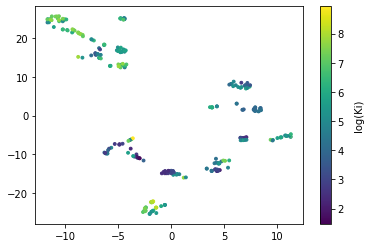

In [11]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

dr=TSNE(random_state=123)
attentions_embed=dr.fit_transform(attentions, )

plt.scatter(attentions_embed[:,0], 
            attentions_embed[:,1],
            c=combined_targets,
            s=8
           )
cbar=plt.colorbar()
cbar.set_label("log(Ki)", labelpad=10)

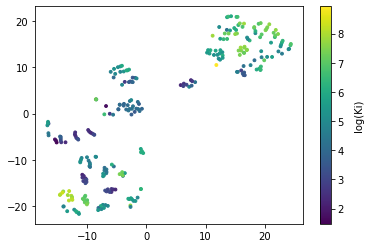

In [12]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

dr=TSNE(random_state=123)
features_embed=dr.fit_transform(combined_features_scaled)

plt.scatter(features_embed[:,0], 
            features_embed[:,1],
            c=combined_targets,
            s=8
           )
cbar=plt.colorbar()
cbar.set_label("log(Ki)", labelpad=10)

### Train XGBRF models w/ and w/o including attention features
Including attention features is detrimental to the model

In [13]:
#Train XGBRF models

from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

expanded_feat=np.hstack([combined_features, attentions])

kf=KFold(n_splits=5, random_state=12345, shuffle=True)
xgbrf_scores=[]
for train_ind, test_ind in kf.split(expanded_feat):
    train_features=expanded_feat[train_ind]
    test_features=expanded_feat[test_ind]
    train_target=combined_targets[train_ind]
    test_target=combined_targets[test_ind]
    
    xgbrf_model=xgb.XGBRFRegressor(n_jobs=-1)
    xgbrf_model.fit(train_features, train_target)
    xgbrf_scores.append(xgbrf_model.score(test_features, test_target))
    del xgbrf_model
    
print(f"{np.mean(xgbrf_scores):.2f} accuracy with a standard deviation of {np.std(xgbrf_scores):.2f}")

0.76 accuracy with a standard deviation of 0.07


In [134]:
#Train XGBRF models

from sklearn.model_selection import KFold
import xgboost as xgb

kf=KFold(n_splits=5, random_state=12345, shuffle=True)
xgbrf_scores=[]
for train_ind, test_ind in kf.split(range(combined_features.shape[0])):
    train_features=combined_features[train_ind]
    test_features=combined_features[test_ind]
    train_target=combined_targets[train_ind]
    test_target=combined_targets[test_ind]
    
    xgbrf_model=xgb.XGBRFRegressor(n_jobs=-1)
    xgbrf_model.fit(train_features, train_target)
    xgbrf_scores.append(xgbrf_model.score(test_features, test_target))
    
    del xgbrf_model
    
print(f"{np.mean(xgbrf_scores):.2f} accuracy with a standard deviation of {np.std(xgbrf_scores):.2f}")

0.80 accuracy with a standard deviation of 0.04


In [ ]:
#Visualize distribution of feature importances
#With attentions
a=xgbrf_model.feature_importances_
plt.bar(range(len(a)), a)

### Test Local-RF, where one RF model is trained for each 'local' cluster determined by hierarchical clustering

In [124]:
import copy
from sklearn.metrics import r2_score
class LocalLinearModel(object):
    def __init__(self, base_clf, ):
        self.base_clf=base_clf
        self.classifiers=[]
        
    def fit(self, X, y, labels_):
        self.clusters=np.unique(labels_)
        for cl_ in self.clusters:
            ind=np.where(labels_==cl_)[0]
            X_subset=X[ind,:]
            y_subset=y[ind]
            
            clf=copy.deepcopy(self.base_clf)
            clf.fit(X_subset, y_subset)
            self.classifiers.append(clf)
    
    def predict(self, X, labels_, ):
        assert np.all(np.isin(labels_, self.clusters)), "Ensure cluster labels were given at training"
        predictions=np.empty(X.shape[0])
        for idx in range(len(self.clusters)):
            cl_=self.clusters[idx]
            clf=self.classifiers[idx]
            if cl_ not in labels_:
                continue
            ind=np.where(labels_==cl_)[0]
            X_subset=X[ind,:]
            
            predictions[ind]=clf.predict(X_subset)
        return predictions
    
    def score(self, X, y, labels_):
        predictions=self.predict(X, labels_)
        score=r2_score(y, predictions)
        return score
    


In [38]:
#Assume locally-linear data structure:
#Apply hierarchical clustering on dataset based on attentions/features, then apply RF

from sklearn.cluster import AgglomerativeClustering
agg=AgglomerativeClustering(n_clusters=2,
                            linkage='ward'
                           )
clustering=agg.fit(combined_features)
print(np.unique(clustering.labels_, return_counts=True))

from sklearn.model_selection import KFold
kf=KFold(n_splits=5, random_state=1234, shuffle=True)
local_xgbrf_scores=[]
for train_ind, test_ind in kf.split(combined_features):
    train_features = combined_features[train_ind]
    train_target = combined_targets[train_ind]
    train_labels_ = clustering.labels_[train_ind]
    test_features = combined_features[test_ind]
    test_target = combined_targets[test_ind]
    test_labels_ = clustering.labels_[test_ind]
    
    local_xgbrf=LocalLinearModel(xgb.XGBRFRegressor(n_jobs=-1))
    local_xgbrf.fit(train_features,
                    train_target,
                    train_labels_
                   )
    local_xgbrf_scores.append(local_xgbrf.score(test_features,
                                                test_target,
                                                test_labels_
                                               ))
print(f"{np.mean(local_xgbrf_scores):.2f} accuracy with a standard deviation of {np.std(local_xgbrf_scores):.2f}")
print(local_xgbrf_scores)

from scipy.stats import ttest_rel
print(ttest_rel(xgbrf_scores, local_xgbrf_scores))

(array([0, 1], dtype=int64), array([180,  98], dtype=int64))
0.79 accuracy with a standard deviation of 0.05
[0.7670541966835351, 0.7016700998629555, 0.8147716869798327, 0.845857691985488, 0.8425940895934266]
Ttest_relResult(statistic=0.09339082763991054, pvalue=0.9300838605121402)


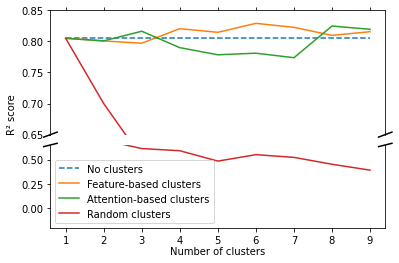

In [138]:
import xgboost as xgb
n_cl_list=list(range(1,10))
rgs=xgb.XGBRFRegressor(n_jobs=-1)
xgbrf_scores_ = experiment(rgs, n_cl_list)                                                                       
f=broken_y_plot(xgbrf_scores_, n_cl_list)

No drop in performance with hierarchical clustering of original features/attentions.

Repeat this and plot a graph with x-axis of number of clusters

In [44]:
#Assume locally-linear data structure:
#Apply hierarchical clustering on dataset based on original features, then apply RF

from sklearn.model_selection import KFold

from sklearn.cluster import AgglomerativeClustering
agg=AgglomerativeClustering(n_clusters=3,
                            linkage='ward'
                           )
clustering=agg.fit(combined_features)
np.unique(clustering.labels_, return_counts=True)

# expanded_feat=np.hstack([combined_features, attentions])

from sklearn.model_selection import RepeatedStratifiedKFold

stratified_kf=RepeatedStratifiedKFold(n_splits=10,
                                      n_repeats=10,
                                      random_state=123
                                     )

local_rf_scores=[]
for train_ind, test_ind in stratified_kf.split(combined_features, 
                                               clustering.labels_):
    train_features=combined_features[train_ind]
    test_features=combined_features[test_ind]
    train_target=combined_targets[train_ind]
    test_target=combined_targets[test_ind]
    train_cl=clustering.labels_[train_ind]
    test_cl=clustering.labels_[test_ind]
    
    local_rf=LocalLinearModel(xgb.XGBRFRegressor(n_jobs=-1))
    local_rf.fit(train_features,
                 train_target,
                 train_cl
                )
    local_rf_scores.append(local_rf.score(test_features,
                                          test_target,
                                          test_cl
                                         ))
    del local_rf
    
print(f"{np.mean(local_rf_scores):.2f} accuracy with a standard deviation of {np.std(local_rf_scores):.2f}")
print(local_rf_scores)

0.77 accuracy with a standard deviation of 0.13
[0.766946662920652, 0.6185865943514842, 0.9195113861304249, 0.7643223492508792, 0.8692076661054932, 0.8278448343442277, 0.8796910111552352, 0.33762065877991765, 0.791332155263596, 0.6865424548100375, 0.8080021368862482, 0.8028746299920204, 0.6969047851084427, 0.7582136175209072, 0.6348049649908203, 0.8571257291374732, 0.9655723916290303, 0.8303204563721107, 0.7944769418661091, 0.8078260077188951, 0.7977135267725117, 0.6254035089266812, 0.861370971707152, 0.8173148932656005, 0.8186421062120927, 0.8277885746436515, 0.8253355644948497, 0.7536839846800659, 0.6031110994350666, 0.6464838724096078, 0.8093983422889655, 0.6624678196176641, 0.8987923447856077, 0.9052767455525794, 0.6213659305485437, 0.7343194714729682, 0.8034268652978135, 0.6502765651139075, 0.9009920995676077, 0.7232776701998347, 0.8635779576559567, 0.3334065698994493, 0.8070946368142076, 0.7630696586094068, 0.87911742553225, 0.8337443164767736, 0.6692617672276358, 0.8229289812823

In [42]:
#Train single XGBRF models 

from sklearn.model_selection import KFold
import xgboost as xgb

# expanded_feat=np.hstack([combined_features, attentions])

stratified_kf=RepeatedStratifiedKFold(n_splits=10, 
                                      n_repeats=10,
                                      random_state=123
                                     )
xgbrf_scores=[]
for train_ind, test_ind in stratified_kf.split(combined_features,
                                               clustering.labels_
                                              ):
    train_features=combined_features[train_ind]
    test_features=combined_features[test_ind]
    train_target=combined_targets[train_ind]
    test_target=combined_targets[test_ind]
    
    xgbrf_model=xgb.XGBRFRegressor(n_jobs=-1)
    xgbrf_model.fit(train_features, train_target)
    xgbrf_scores.append(xgbrf_model.score(test_features, test_target))
    del xgbrf_model
    
print(f"{np.mean(xgbrf_scores):.2f} accuracy with a standard deviation of {np.std(xgbrf_scores):.2f}")
print(xgbrf_scores)

0.79 accuracy with a standard deviation of 0.10
[0.9142665197525216, 0.7623631067568846, 0.9330991235805557, 0.7439100757520762, 0.8629074692885995, 0.6643844903983502, 0.7611871822486754, 0.8794179924704135, 0.5554955991046423, 0.6875774167460553, 0.846628494849564, 0.9068394334075818, 0.7759475016071655, 0.6829044796718744, 0.8546688559329867, 0.9099492103536717, 0.7566851679904815, 0.8076841178023217, 0.7455998420807463, 0.851672835293423, 0.8539954679584997, 0.8400183491507278, 0.8303025138807101, 0.7177201737184489, 0.8119963992206448, 0.38278145256896745, 0.8122167049222379, 0.7849159207085594, 0.8735739656896125, 0.848351961882722, 0.7190821345353732, 0.6093595010998069, 0.8436101484337389, 0.7884595994170669, 0.7789033107786296, 0.9318032407791508, 0.8240293962586248, 0.8973289356945398, 0.8489584945133086, 0.8150449619615959, 0.6517905768581849, 0.7818390985027457, 0.8361603629542232, 0.6531049583151991, 0.7900303004406555, 0.7666515125254403, 0.7977265249631286, 0.87296338208

In [46]:
from scipy.stats import ttest_rel
ttest_rel(local_rf_scores, xgbrf_scores)

Ttest_relResult(statistic=-1.2229215148587078, pvalue=0.22426251982928966)

Not much loss of performance with local RF models

## Dataset-based Quantitative Analysis (Ridge Regression)

Not sure why Linear Regression gives such crazy prediction values. Ridge regression gives 'more reasonable' prediction values. May be due to its internal regularization procedures. 

In [216]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import Ridge
lr = Ridge()
y_pred = cross_val_predict(lr,
                           combined_features_scaled,
                           combined_targets,
                           cv=LeaveOneOut()
                           )
ridge_score=r2_score(combined_targets, y_pred)

In [127]:
"""This version of LocalLinearModel assumes that clustering label is in the last feature. For compatibility with sklearn.model_selection modules"""

class LocalLinearModelv2(object):
    def __init__(self, base_clf):
        self.base_clf = base_clf
        
    def fit(self, X, y=None):
        X, labels_=self._get_labels(X)
        self.clusters=np.unique(labels_)
        self.classifiers=[]
        for cl_ in self.clusters:
            ind=np.where(labels_==cl_)[0]
            X_subset=X[ind,:]
            if y is not None:
                y_subset=y[ind]
            else:
                y_subset=None
            clf=copy.deepcopy(self.base_clf)
            clf.fit(X_subset, y_subset)
            self.classifiers.append(clf)
            
    def predict(self, X, ):
        X, labels_=self._get_labels(X)
        assert np.all(np.isin(labels_, self.clusters)), "Ensure cluster labels were given at training"        
        predictions=np.empty(X.shape[0])
        for idx in range(len(self.clusters)):
            cl_=self.clusters[idx]
            clf=self.classifiers[idx]
            if cl_ not in labels_:
                continue
            ind=np.where(labels_==cl_)[0]
            X_subset=X[ind,:]
            
            predictions[ind]=clf.predict(X_subset)
        return predictions                
    
    def get_params(self, deep=True):
        out=dict()
        for key in self.__dict__:
            value=getattr(self, key)
            if deep and hasattr(value, 'get_params'):
                deep_items=value.get_params().items()
                out.update((key +'__'+k, val) for k, val in deep_items)
            out[key]=value
        return out
    
    @staticmethod
    def _get_labels(X):
        if X.ndim==2:
            return X[:,:-1], X[:,-1]
        elif X.ndim==1:
            return X[:-1],  X[-1]
    

(array([0], dtype=int64), array([278], dtype=int64))
(array([0, 1], dtype=int64), array([180,  98], dtype=int64))
(array([0, 1, 2], dtype=int64), array([ 98, 107,  73], dtype=int64))
(array([0, 1, 2, 3], dtype=int64), array([107,  74,  73,  24], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([74, 57, 73, 24, 50], dtype=int64))
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([73, 57, 49, 24, 50, 25], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([57, 57, 49, 24, 50, 25, 16], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([57, 24, 49, 28, 50, 25, 16, 29], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([49, 24, 25, 28, 50, 39, 16, 29, 18], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([24, 50, 25, 28, 36, 39, 16, 29, 18, 13], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64), array([50, 28, 25, 29, 36, 39, 16, 11, 18, 13, 13], dtype=int64))
(array([ 0,  1,  2,  3

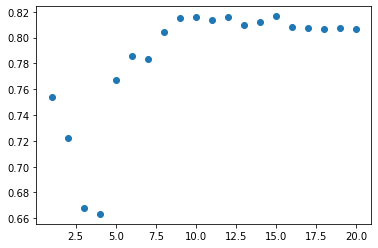

In [239]:
#Get clusters
r2_scores=[]
n_cl_list=list(range(1,21))
for n_cl in n_cl_list:
    from sklearn.cluster import AgglomerativeClustering
    agg=AgglomerativeClustering(n_clusters=n_cl,
                                linkage='ward'
                               )
    clustering=agg.fit(combined_features)
    print(np.unique(clustering.labels_, return_counts=True))

    #Fit Local Linear Model
    from sklearn.linear_model import Ridge
    local_LR=LocalLinearModelv2(Ridge(),)
    y_pred = cross_val_predict(local_LR,
                               np.hstack([combined_features_scaled,
                                          np.expand_dims(clustering.labels_,axis=1)]),
                               combined_targets,
                               cv=LeaveOneOut()
                               )
    r2_scores.append(r2_score(combined_targets, y_pred))


In [240]:
r2_scores_att=[]
for n_cl in n_cl_list:
    #Get clusters
    from sklearn.cluster import AgglomerativeClustering
    agg=AgglomerativeClustering(n_clusters=n_cl,
                                linkage='ward'
                               )
    clustering=agg.fit(attentions)
    print(np.unique(clustering.labels_, return_counts=True))

    #Fit Local Linear Model
    from sklearn.linear_model import Ridge
    local_LR=LocalLinearModelv2(Ridge(),)
    y_pred = cross_val_predict(local_LR,
                               np.hstack([combined_features_scaled,
                                          np.expand_dims(clustering.labels_,axis=1)]),
                               combined_targets,
                               cv=LeaveOneOut()
                               )
    r2_scores_att.append(r2_score(combined_targets, y_pred))



(array([0], dtype=int64), array([278], dtype=int64))
(array([0, 1], dtype=int64), array([181,  97], dtype=int64))
(array([0, 1, 2], dtype=int64), array([94, 97, 87], dtype=int64))
(array([0, 1, 2, 3], dtype=int64), array([87, 97, 63, 31], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([97, 31, 63, 58, 29], dtype=int64))
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([63, 31, 87, 58, 29, 10], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([31, 48, 87, 58, 29, 10, 15], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([87, 48, 21, 58, 29, 10, 15, 10], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([48, 58, 21, 10, 29, 10, 15, 40, 47], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([58, 27, 21, 10, 29, 10, 15, 40, 47, 21], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64), array([39, 27, 21, 10, 29, 10, 15, 40, 47, 21, 19], dtype=int64))
(array([ 0,  1,  2,  3,  4,  

In [241]:
r2_scores_rand=[]
for n_cl in n_cl_list:
    #Get clusters
    from sklearn.cluster import AgglomerativeClustering
    agg=AgglomerativeClustering(n_clusters=n_cl,
                                linkage='ward'
                               )
    clustering=agg.fit(attentions)
    
    n=combined_features.shape[0]
    a, p=np.unique(clustering.labels_, return_counts=True)
    p=p/np.sum(p)
    random_labels_=np.random.choice(a, 
                                size=n,
                                replace=True, 
                                p=p
                               )
    print(np.unique(random_labels_, return_counts=True))

    #Fit Local Linear Model
    from sklearn.linear_model import Ridge
    local_LR=LocalLinearModelv2(Ridge(),)
    y_pred = cross_val_predict(local_LR,
                               np.hstack([combined_features_scaled,
                                          np.expand_dims(random_labels_,axis=1)]),
                               combined_targets,
                               cv=LeaveOneOut()
                               )
    r2_scores_rand.append(r2_score(combined_targets, y_pred))



(array([0], dtype=int64), array([278], dtype=int64))
(array([0, 1], dtype=int64), array([195,  83], dtype=int64))
(array([0, 1, 2], dtype=int64), array([94, 90, 94], dtype=int64))
(array([0, 1, 2, 3], dtype=int64), array([92, 99, 53, 34], dtype=int64))
(array([0, 1, 2, 3, 4], dtype=int64), array([98, 21, 72, 54, 33], dtype=int64))
(array([0, 1, 2, 3, 4, 5], dtype=int64), array([68, 36, 80, 55, 30,  9], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([40, 52, 93, 50, 27,  7,  9], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([85, 44, 24, 56, 33,  8, 15, 13], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([52, 59, 17,  7, 19, 13, 18, 46, 47], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([65, 23, 12, 11, 28,  8, 17, 40, 42, 32], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64), array([33, 24, 23, 11, 24,  6, 13, 42, 47, 19, 36], dtype=int64))
(array([ 0,  1,  2,  3,  4,  

Text(0, 0, 'R² score')

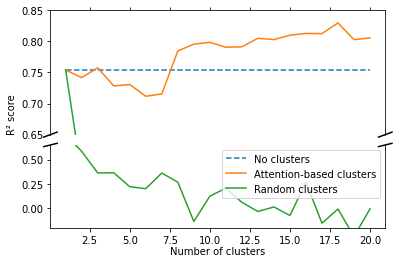

In [343]:
%matplotlib inline
import matplotlib.pyplot as plt

f, (ax, ax2)=plt.subplots(2,1, sharex=True, 
                          gridspec_kw={"height_ratios":[0.6,0.4]}
                         )
ax.plot(n_cl_list, np.ones(len(n_cl_list))*ridge_score, 
         linestyle='--',
         label="No clusters")
# ax.plot(n_cl_list, r2_scores, label="Feature-based clusters")
ax.plot(n_cl_list, r2_scores_att, label="Attention-based clusters")
ax.plot(n_cl_list, r2_scores_rand, label="Random clusters")
ax2.plot(n_cl_list, np.ones(len(n_cl_list))*ridge_score, 
         linestyle='--',
         label="No clusters")
# ax2.plot(n_cl_list, r2_scores, label="Feature-based clusters")
ax2.plot(n_cl_list, r2_scores_att, label="Attention-based clusters")
ax2.plot(n_cl_list, r2_scores_rand, label="Random clusters")

ax.set_ylim(0.65, 0.85)
ax2.set_ylim(-0.2,0.65)

#hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

#cut-out diagonal lines on spines
d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

f.subplots_adjust(hspace=0.1)

plt.legend()
plt.xlabel("Number of clusters", labelpad=1)
ax.set_ylabel("R\u00B2 score", loc='bottom')



### Looping

In [123]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score
import copy
from sklearn.cluster import AgglomerativeClustering

def experiment(rgs, 
               n_cl_list=list(range(1, 19)), 
               return_train=False
              ):
    single_model = copy.deepcopy(rgs)
    y_pred = cross_val_predict(rgs,
                               combined_features_scaled,
                               combined_targets,
                               cv=LeaveOneOut()
                               )
    single_score = r2_score(combined_targets, y_pred)

    local_scores = []
    local_scores_att = []
    local_scores_rand = []
    for n_cl in n_cl_list:
        model = copy.deepcopy(LocalLinearModelv2(rgs))
        local_scores.append(exp_step(n_cl,
                                     combined_features_scaled,
                                     model))
        local_scores_att.append(exp_step(n_cl,
                                         attentions,
                                         model
                                         ))
        local_scores_rand.append(exp_step(n_cl,
                                          combined_features_scaled,
                                          model,
                                          random=True
                                          ))
    return single_score, local_scores, local_scores_att, local_scores_rand


def exp_step(n_cl, cluster_X, clf, random=False):
    agg = AgglomerativeClustering(n_clusters=n_cl,
                                  linkage='ward'
                                  )
    clustering = agg.fit(cluster_X)
    labels_ = clustering.labels_
    if random:
        n = combined_features_scaled.shape[0]
        a, p = np.unique(clustering.labels_, return_counts=True)
        p = p/np.sum(p)
        random_labels_ = np.random.choice(a,
                                          size=n,
                                          replace=True,
                                          p=p
                                          )
        labels_ = random_labels_
    y_pred = cross_val_predict(clf,
                               np.hstack([combined_features_scaled,
                                          np.expand_dims(labels_, axis=1)]),
                               combined_targets,
                               cv=LeaveOneOut()
                               )
    return r2_score(combined_targets, y_pred)


%matplotlib inline


def broken_y_plot(scores, n_cl_list, ylims=[(-0.2,0.65),(0.65,0.85)]):
    single_score = scores[0]
    local_scores = scores[1]
    local_scores_att = scores[2]
    local_scores_rand = scores[3]

    f, (ax, ax2) = plt.subplots(2, 1, sharex=True,
                                gridspec_kw={"height_ratios": [0.6, 0.4]}
                                )
    ax.plot(n_cl_list, np.ones(len(n_cl_list))*single_score,
            linestyle='--',
            label="No clusters")
    ax.plot(n_cl_list, local_scores, label="Feature-based clusters")
    ax.plot(n_cl_list, local_scores_att, label="Attention-based clusters")
    ax.plot(n_cl_list, local_scores_rand, label="Random clusters")
    ax2.plot(n_cl_list, np.ones(len(n_cl_list))*single_score,
             linestyle='--',
             label="No clusters")
    ax2.plot(n_cl_list, local_scores, label="Feature-based clusters")
    ax2.plot(n_cl_list, local_scores_att, label="Attention-based clusters")
    ax2.plot(n_cl_list, local_scores_rand, label="Random clusters")

    ax.set_ylim(ylims[1][0], ylims[1][1])
    ax2.set_ylim(ylims[0][0], ylims[0][1])

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)
    ax2.xaxis.tick_bottom()

    # cut-out diagonal lines on spines
    d = .02  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    f.subplots_adjust(hspace=0.1)

    plt.legend()
    plt.xlabel("Number of clusters", labelpad=1)
    ax.set_ylabel("R\u00B2 score", loc='bottom')

    return f


def plot_scores(scores, n_cl_list, ylim=(0.1,0.9)):
    single_score = scores[0]
    local_scores = scores[1]
    local_scores_att = scores[2]
    local_scores_rand = scores[3]
    f, ax = plt.subplots(1, 1,)

    ax.plot(n_cl_list, np.ones(len(n_cl_list))*single_score,
            linestyle='--',
            label="No clusters")
    ax.plot(n_cl_list, local_scores, label="Feature-based clusters")
    ax.plot(n_cl_list, local_scores_att, label="Attention-based clusters")
    ax.plot(n_cl_list, local_scores_rand, label="Random clusters")

    plt.legend()
    plt.xlabel("Number of clusters", labelpad=1)
    ax.set_ylabel("R\u00B2 score",)
    ax.set_ylim(ylim[0], ylim[1])
    return f

### HuberRegressor
Linear regression (No regularization)

We get crazy losses because of crazy intercept values!! Try using HuberRegressor instead: "Robust to outliers"

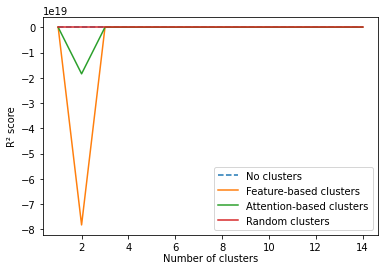

In [18]:
from sklearn.linear_model import LinearRegression
n_cl_list=list(range(1,15))
rgs=LinearRegression()
linear_scores_ = experiment(rgs, n_cl_list)

f=plot_scores(linear_scores_, n_cl_list)

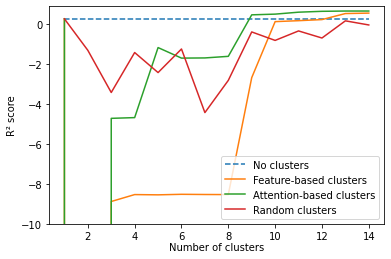

In [29]:
f.axes[0].set_ylim((-10,0.9))
f


In [ ]:
#Combined_features_scaled have high values (4+) for some features
np.max(combined_features_scaled)

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (

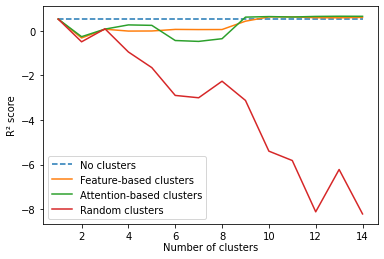

In [121]:
from sklearn.linear_model import HuberRegressor
n_cl_list=list(range(1,15))
rgs=HuberRegressor(max_iter=10000, tol=1e-03,)
linear_scores_ = experiment(rgs, n_cl_list)



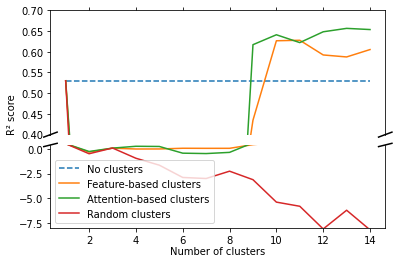

In [129]:
f=broken_y_plot(linear_scores_, n_cl_list,
                ylims=[(-8, 0.4),(0.4, 0.7)]
               )

### Ridge regression uses L2 regularization

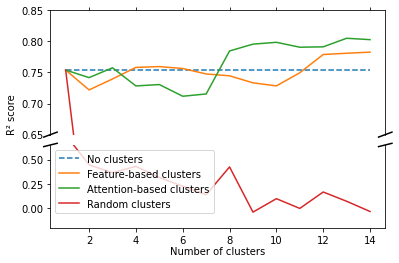

In [330]:
n_cl_list=list(range(1,15))
rgs=Ridge()
ridge_scores_ = experiment(rgs, n_cl_list)                                                                       
f=broken_y_plot(ridge_scores_, n_cl_list)

### Lasso uses L1 regularization

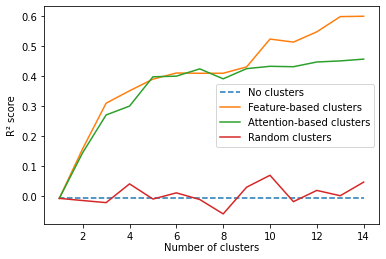

In [135]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict, LeaveOneOut
alpha_list=np.logspace(-4,0, num=9)
lasso_scores=[]
for a in alpha_list:
    rgs=Lasso(alpha=a, 
              max_iter=1E6, 
              random_state=123,
              selection='random'
             )
    prediction=cross_val_predict(rgs, 
                                 combined_features_scaled,
                                 combined_targets,
                                 cv=LeaveOneOut()
                                )
    lasso_scores.append(r2_score(combined_targets, 
                                 prediction))

Text(0.5, 0, 'alpha')

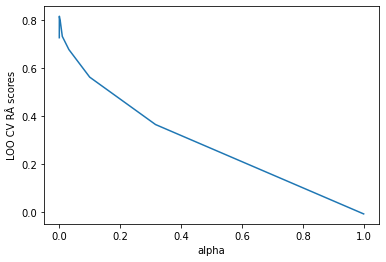

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(alpha_list, lasso_scores)
plt.ylabel("LOO CV R\u00B2 scores")
plt.xlabel("alpha")

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


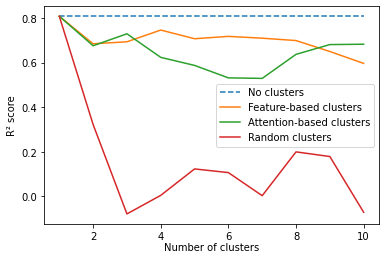

In [143]:
n_cl_list=list(range(1,11))
from sklearn.linear_model import Lasso
alpha=0.001
rgs=Lasso(alpha=alpha, max_iter=1E6, random_state=123,
         selection='random')
lasso_scores_ = experiment(rgs, n_cl_list) 

f=plot_scores(lasso_scores_, n_cl_list)

I suspect that with more clusters, we need higher regularization values. However, low regularization values appear to require higher number of iterations. 

### Elastic net uses both L1 and L2 regularization

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

rgs=ElasticNet(alpha=a, l1_ratio=0.5, max_iter=1000)
param_grid={'alpha': np.logspace(-4,0,num=9), 
            'l1_ratio': np.arange(start=-1,stop=0, step=0.2)
           }
cv=GridSearchCV(rgs,
                param_grid,
                cv=LeaveOneOut())
cv.fit(combined_features_scaled, 
       combined_targets
      )


In [ ]:
cv.cv_results_.keys()

### PLS Regression - supposedly more robust to measurement uncertainty

In [180]:
from sklearn.cross_decomposition import PLSRegression
pls_scores_=[]
for n_comp in list(range(1, 20)):
    rgs=PLSRegression(n_components=n_comp)
    y_pred=cross_val_predict(rgs,
                             combined_features_scaled,
                             combined_targets,
                             cv=LeaveOneOut()
                            )
    pls_scores_.append(r2_score(combined_targets,y_pred))

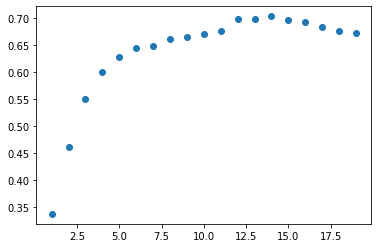

In [181]:
plt.scatter(list(range(1,20)), pls_scores_)

Influence of number of components on test accuracy

In [184]:
from sklearn.cross_decomposition import PLSRegression
pls_train_scores_=[]
pls_train_scores_std_=[]
for n_comp in list(range(1, 20)):
    rgs=PLSRegression(n_components=n_comp)
    rgs_cv = cross_validate(rgs,
                            combined_features_scaled,
                            combined_targets,
                            cv=LeaveOneOut(), 
                            return_train_score=True
                           )
    train_scores=rgs_cv['train_score']
    pls_train_scores_.append(np.mean(train_scores))
    pls_train_scores_std_.append(np.std(train_scores))

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\cavio\appdata\local\programs\python\python38\lib\si

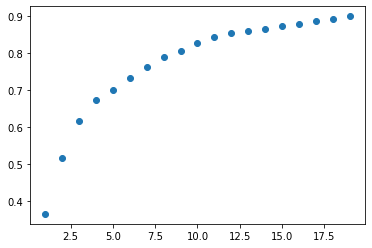

In [185]:
plt.scatter(list(range(1,20)), pls_train_scores_)

Influence of number of components on train accuracy

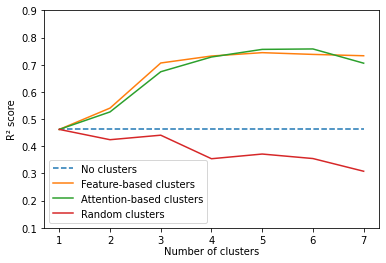

In [194]:
from sklearn.cross_decomposition import PLSRegression
n_cl_list=list(range(1,8))
rgs=PLSRegression(n_components=2)
PLSR_scores_=experiment(rgs, n_cl_list)
f=plot_scores(PLSR_scores_, n_cl_list, ylim=(0.1,0.9))

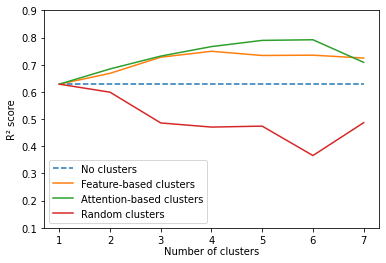

In [195]:
from sklearn.cross_decomposition import PLSRegression
n_cl_list=list(range(1,8))
rgs=PLSRegression(n_components=5)
PLSR_scores_=experiment(rgs, n_cl_list)
f=plot_scores(PLSR_scores_, n_cl_list)

We get a warning for "Y residual constant at iteration 9". This suggests that the Y has been "fully explained" by the preceding 9 components in X. It's possible that we are only getting this error in the procedure that is splitting the dataset into smaller clusters, resulting in smaller subsets of data that can be explained by fewer components.  

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 4
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

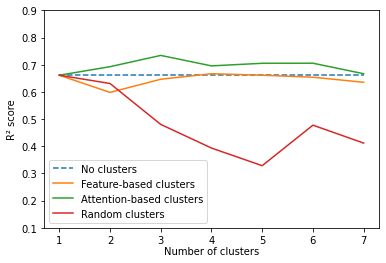

In [196]:
from sklearn.cross_decomposition import PLSRegression
n_cl_list=list(range(1,8))
rgs=PLSRegression(n_components=8)
PLSR_scores_=experiment(rgs, n_cl_list)
f=plot_scores(PLSR_scores_, n_cl_list)

We pick an intermediary value for n_components (so that we can retain PLS's removal of noise principal components while explaining a substantial amount of variance in Y). 

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 5
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 6
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 5
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

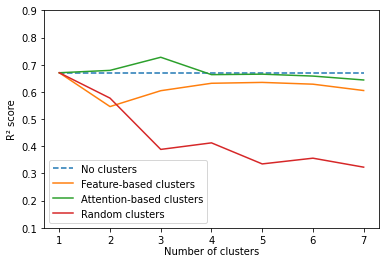

In [197]:
from sklearn.cross_decomposition import PLSRegression
n_cl_list=list(range(1,8))
rgs=PLSRegression(n_components=10)
PLSR_scores_=experiment(rgs, n_cl_list)
f=plot_scores(PLSR_scores_, n_cl_list)

### OPLS with PLS Regression

In [224]:
from pyopls import OPLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
#Consider using Lasso, ElasticNet or Ridge based on above
#Consider introducing some kind of clipping 
from sklearn.base import BaseEstimator
from collections import defaultdict

class OPLS_OLSRegressor(BaseEstimator):
    def __init__(self, n_components=10, 
                 scale=False, #Test out scaling y values
                 lr_kwargs={}
                ):
        self.n_components=n_components
        self.scale=scale
        self.lr_kwargs=lrkwargs


    def fit(self, features, targets):
        self.opls = OPLS(n_components=self.n_components,
                         scale=self.scale)
        self.rgs = LinearRegression(**self.lr_kwargs)
    
        self.Z = self.opls.fit_transform(features, targets)
        self.rgs.fit(self.Z, targets)

    def predict(self, features):
        prediction = self.opls.transform(features)
        prediction = self.rgs.predict(prediction)
        return prediction

    def score(self, features, targets):
        predictions = self.predict(features)
        score = r2_score(targets, predictions)
        return score

    def get_params(self, deep=True):
        out = dict()
        for key in self.__dict__:
            if np.any(np.isin(key, ['opls', 'rgs', 'Z'])):
                continue
            value = getattr(self, key)
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__'+k, val) for k, val in deep_items)
            out[key] = value
        return out

class OPLS_PLSRegressor(BaseEstimator):
    def __init__(self, n_components=10, scale=False,
                 pls_kwargs={
                     'n_components':10
                 }
                ):
        self.n_components=n_components
        self.scale=scale
        self.pls_kwargs=pls_kwargs
        
    def fit(self, features, targets):
        self.opls = OPLS(n_components=self.n_components, 
                         scale=self.scale)
        self.pls = PLSRegression(**self.pls_kwargs)        
        
        self.Z = self.opls.fit_transform(features, targets)
        self.pls.fit(self.Z, targets)

    def predict(self, features):
        prediction = self.opls.transform(features)
        prediction = self.pls.predict(prediction)
        return prediction

    def score(self, features, targets):
        predictions = self.predict(features)
        score = r2_score(targets, predictions)
        return score                
    
    def get_params(self, deep=True):
        out = dict()
        for key in self.__dict__:
            if np.any(np.isin(key, ['opls', 'pls', 'Z'])):
                continue
            value = getattr(self, key)
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__'+k, val) for k, val in deep_items)
            out[key] = value
        return out
    
class LocalLinearOPLS(BaseEstimator):
    def __init__(self, opls_kwargs, plsr_kwargs, **kwargs):
        self.opls_kwargs=opls_kwargs
        self.plsr_kwargs=plsr_kwargs

    def fit(self, X, y=None):
        self.opls = OPLS(**self.opls_kwargs)
        self.plsr = PLSRegression(**self.plsr_kwargs)
        
        X, labels_=self._get_labels(X)
        self.Z=self.opls.fit_transform(X, y)
        
        self.clusters=np.unique(labels_)
        self.classifiers=[]
        for cl_ in self.clusters:
            ind=np.where(labels_==cl_)[0]
            X_subset=X[ind,:]
            if y is not None:
                y_subset=y[ind]
            else:
                y_subset=None
            plsr=copy.deepcopy(self.plsr)
            plsr.fit(X_subset, y_subset)
            self.classifiers.append(plsr)
            
    def predict(self, X, ):
        X, labels_=self._get_labels(X)
        z=self.opls.transform(X)
        assert np.all(np.isin(labels_, self.clusters)), "Ensure cluster labels were given at training"        
        predictions=np.empty(X.shape[0])
        for idx in range(len(self.clusters)):
            cl_=self.clusters[idx]
            plsr=self.classifiers[idx]
            if cl_ not in labels_:
                continue
            ind=np.where(labels_==cl_)[0]
            X_subset=X[ind,:]
            
            predictions[ind]=plsr.predict(X_subset).flatten()
        return predictions                
    
    def get_params(self, deep=True):
        out=dict()
        for key in self.__dict__:
            value=getattr(self, key)
            if np.any(np.isin(key, ['opls', 'plsr', 'Z', 'clusters', 'classifiers'])):
                continue            
            if deep and hasattr(value, 'get_params'):
                deep_items=value.get_params().items()
                out.update((key +'__'+k, val) for k, val in deep_items)
            out[key]=value
        return out
    
    @staticmethod
    def _get_labels(X):
        if X.ndim==2:
            return X[:,:-1], X[:,-1]
        elif X.ndim==1:
            return X[:-1],  X[-1]    

In [234]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4,
                              linkage='ward'
                             )

ll_opls=LocalLinearOPLS(opls_kwargs={'n_components':10,
                                     'scale': True
                                    },
                        plsr_kwargs={'n_components':10,
                                     'scale':False
                                    }
                       )
X_w_cl=np.hstack([combined_features_scaled,
            np.expand_dims(labels_, axis=1)])
          
ll_opls.fit(X_w_cl, 
            combined_targets
           )

predictions=ll_opls.predict(X_w_cl,)
r2_score(combined_targets, predictions)

0.9552189833585224

In [235]:
from sklearn.model_selection import cross_val_predict
y_pred=cross_val_predict(ll_opls, 
                         X_w_cl, 
                         combined_targets,
                         cv=LeaveOneOut()
                        )
r2_score(combined_targets, y_pred)

0.7470749973488892

In [236]:
local_scores = []
local_scores_att = []
local_scores_rand = []
n_cl_list=list(range(1,8))
for n_cl in n_cl_list:
    model = LocalLinearOPLS(opls_kwargs={'n_components':10,
                                         'scale':True,
                                        },
                            plsr_kwargs={'n_components':10,
                                         'scale':False
                                        }
                           )
    local_scores.append(exp_step(n_cl,
                                 combined_features_scaled,
                                 model))
    local_scores_att.append(exp_step(n_cl,
                                     attentions,
                                     model
                                     ))
    local_scores_rand.append(exp_step(n_cl,
                                      combined_features_scaled,
                                      model,
                                      random=True
                                      ))


c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

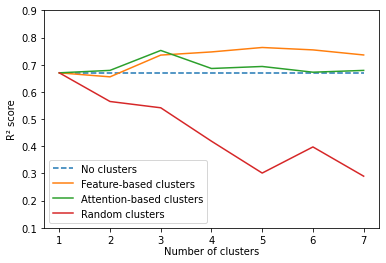

In [237]:
f=plot_scores([local_scores[0],
             local_scores, 
             local_scores_att,
             local_scores_rand
            ], 
            list(range(1,8))
           )

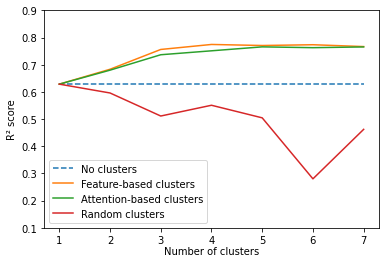

In [239]:
local_scores = []
local_scores_att = []
local_scores_rand = []
n_cl_list=list(range(1,8))
for n_cl in n_cl_list:
    model = LocalLinearOPLS(opls_kwargs={'n_components':10,
                                         'scale':True,
                                        },
                            plsr_kwargs={'n_components':5,
                                         'scale':False
                                        }
                           )
    local_scores.append(exp_step(n_cl,
                                 combined_features_scaled,
                                 model))
    local_scores_att.append(exp_step(n_cl,
                                     attentions,
                                     model
                                     ))
    local_scores_rand.append(exp_step(n_cl,
                                      combined_features_scaled,
                                      model,
                                      random=True
                                      ))
f=plot_scores([local_scores[0],
             local_scores, 
             local_scores_att,
             local_scores_rand
            ], 
            list(range(1,8))
           )

In [242]:
local_scores = []
local_scores_att = []
local_scores_rand = []
n_cl_list=list(range(1,8))
for n_cl in n_cl_list:
    model = LocalLinearOPLS(opls_kwargs={'n_components':10,
                                         'scale':True,
                                        },
                            plsr_kwargs={'n_components':15,
                                         'scale':False
                                        }
                           )
    local_scores.append(exp_step(n_cl,
                                 combined_features_scaled,
                                 model))
    local_scores_att.append(exp_step(n_cl,
                                     attentions,
                                     model
                                     ))
    local_scores_rand.append(exp_step(n_cl,
                                      combined_features_scaled,
                                      model,
                                      random=True
                                      ))
f=plot_scores([local_scores[0],
             local_scores, 
             local_scores_att,
             local_scores_rand
            ], 
            list(range(1,8))
           )

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 7
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWar

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 13
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 8
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 13
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 13
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 14
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 9
  warnings.warn('Y residual constant at iteration %s' % k)
c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserW

ValueError: Found array with 1 sample(s) (shape=(1, 146)) while a minimum of 2 is required.

Do a 'score' of OPLS to see how much of the 'variance' was explained

### Principal components regression?

In [246]:
#Principal components regression?
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

pcr=make_pipeline(PCA(n_components=10), 
                  LinearRegression())
pcr.fit(combined_features_scaled, combined_targets)
y_pred=pcr.predict(combined_features_scaled)

In [247]:
r2_score(combined_targets, 
         y_pred
        )

0.571997551498473

## Neighborhood-based Molecular visualization
What can we learn from the clusters found? 
Switch over to conda kernel for RDKit package!

In [15]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3,
                              linkage='ward'
                             )
agg.fit(attentions)
labels_=agg.labels_

In [18]:
smiles=df2['SMILES Notation']

In [19]:
#Get Morgan fingerprints
from rdkit.Chem import MolFromSmiles, rdMolDescriptors

ms= [MolFromSmiles(x) for x in smiles]
fps=[rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, 2048) for m in ms]

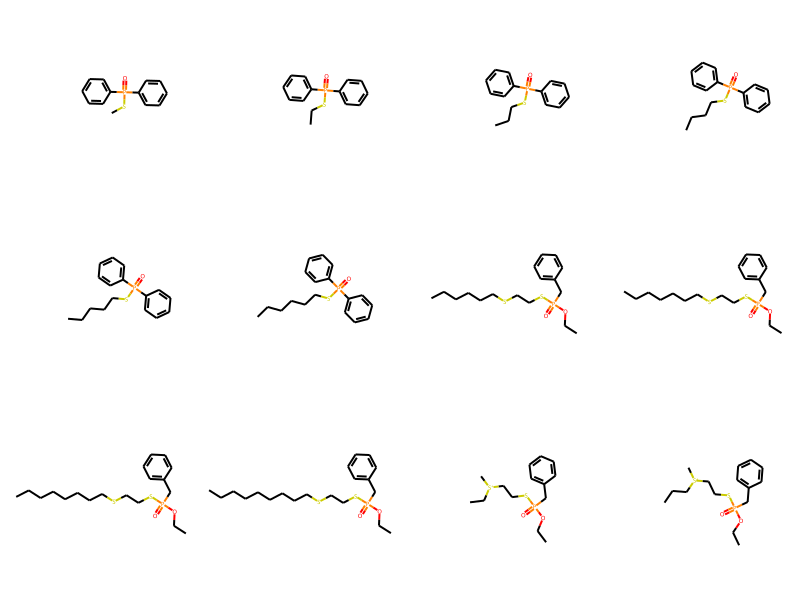

In [21]:
from rdkit import DataStructs
from rdkit.Chem import Draw
cl_ind=np.where(labels_==0)[0]
Draw.MolsToGridImage([ms[x] for x in cl_ind[:12]], 
                     molsPerRow=4)

In [27]:
from rdkit import DataStructs

sims=DataStructs.BulkTanimotoSimilarity(
    fps[cl_ind[0]], [fps[i] for i in cl_ind]
)

In [31]:
def intracluster_similarities(cluster, fps):
    res=[]
    cfps = [fps[x] for x in cluster]
    for i, fpid in enumerate(cluster):
        tres=DataStructs.BulkTanimotoSimilarity(cfps[i], cfps)
        del tres[i]
        res.extend(tres)
    return res

In [43]:
clusters=[]
cl_=np.unique(labels_)
for i in cl_:
    clusters.append(np.where(labels_==i)[0])
intracluster_similarities(clusters[0], fps)

[0.5769230769230769,
 0.5357142857142857,
 0.5,
 0.4838709677419355,
 0.46875,
 0.23404255319148937,
 0.23404255319148937,
 0.23404255319148937,
 0.23404255319148937,
 0.24444444444444444,
 0.26666666666666666,
 0.22916666666666666,
 0.22448979591836735,
 0.22,
 0.22,
 0.3170731707317073,
 0.22,
 0.20833333333333334,
 0.2127659574468085,
 0.22,
 0.3023255813953488,
 0.21153846153846154,
 0.16666666666666666,
 0.17391304347826086,
 0.1836734693877551,
 0.2619047619047619,
 0.17647058823529413,
 0.10416666666666667,
 0.09803921568627451,
 0.10204081632653061,
 0.35135135135135137,
 0.2413793103448276,
 0.5,
 0.3939393939393939,
 0.37142857142857144,
 0.35135135135135137,
 0.3333333333333333,
 0.2682926829268293,
 0.275,
 0.24444444444444444,
 0.3170731707317073,
 0.28205128205128205,
 0.2619047619047619,
 0.2682926829268293,
 0.3333333333333333,
 0.17777777777777778,
 0.10638297872340426,
 0.10638297872340426,
 0.10204081632653061,
 0.1,
 0.09803921568627451,
 0.09803921568627451,
 0.098

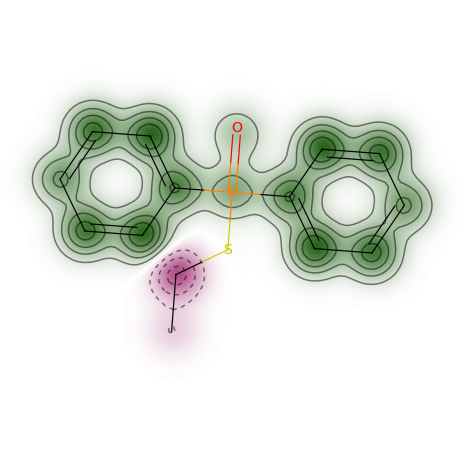

In [70]:
#Generating Similarity Maps using Fingerprints
from rdkit.Chem.Draw import SimilarityMaps
fig, maxweight=SimilarityMaps.GetSimilarityMapForFingerprint(
    ms[clusters[0][0]], 
    ms[clusters[0][1]],
    SimilarityMaps.GetMorganFingerprint,
    metric=DataStructs.TanimotoSimilarity
)

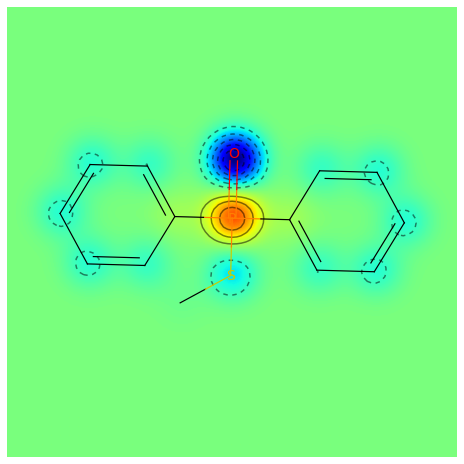

In [73]:
# Visualization of descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import SimilarityMaps
mol = ms[clusters[0][0]]
AllChem.ComputeGasteigerCharges(mol)
contribs = [mol.GetAtomWithIdx(i).GetDoubleProp(
    '_GasteigerCharge') for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(
    mol, contribs, colorMap='jet', contourLines=10)

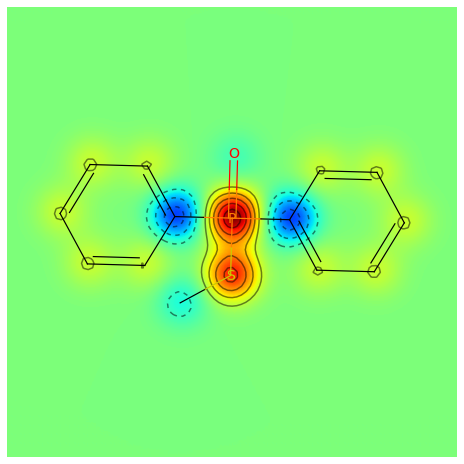

In [75]:
contribs = rdMolDescriptors._CalcCrippenContribs(mol)
fig = SimilarityMaps.GetSimilarityMapFromWeights(
    mol, [x for x, y in contribs], colorMap='jet', contourLines=10)

In [78]:
# Chemical features and pharmacophores
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import os
#Build a feature factory
fdefName = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

#Use feature factor to search for features
mol=ms[clusters[0][0]]
feats=factory.GetFeaturesForMol(mol)
len(feats)

7

In [80]:
feats[0].GetFamily()
feats[0].GetType()

'SingleAtomAcceptor'

In [84]:
#Molecular fragments

fname=os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
from rdkit.Chem import FragmentCatalog
fparams=FragmentCatalog.FragCatParams(1,6,fname)
fparams.GetNumFuncGroups()
fcat=FragmentCatalog.FragCatalog(fparams)
fcgen=FragmentCatalog.FragCatGenerator()
mol=ms[clusters[0][0]]
fcgen.AddFragsFromMol(mol, fcat)
fcat.GetEntryDescription(0)

'cP(<-SCH3>)<=O>'

### Pick out Morgan FP bits relating to attention clusters

In [268]:
from rdkit.ML.InfoTheory import InfoBitRanker
ranker = InfoBitRanker(len(fps[0]), 2)
acts = df2['Logki'].values
for i, fp in enumerate(fps):
    act = int(acts[i] > 7)
    ranker.AccumulateVotes(fp, act)
top5 = ranker.GetTopN(10)
for id, gain, n0, n1 in top5:
    print(int(id), '%.3f' % gain, int(n0), int(n1))

640 0.065 28 23
1819 0.059 3 10
585 0.053 4 10
276 0.053 4 10
644 0.047 5 10
764 0.047 5 10
766 0.046 20 17
178 0.046 20 17
1244 0.045 0 5
370 0.045 0 5


bitId, infoGain, nInactive, nActive

Re-purpose this to determine what sets one cluster apart from the rest of the dataset


In [249]:
from rdkit.ML.InfoTheory import InfoBitRanker
ranker=InfoBitRanker(len(fps[0]), 2) #Ranking of Morgan FPs
cl=1
for i, fp in enumerate(fps):
    in_cl=int(labels_[i]==cl)
    ranker.AccumulateVotes(fp, in_cl)
topN = ranker.GetTopN(20)
print(f"bitID, infoGain, n_Inactive, n_Active")
for id, gain, n0, n1 in topN:
    print(f"{int(id)}, {gain:.3f}, {n0}, {n1}")

bitID, infoGain, n_Inactive, n_Active
116, 0.188, 180.0, 63.0
807, 0.175, 0.0, 29.0
725, 0.156, 0.0, 26.0
1595, 0.156, 0.0, 26.0
431, 0.156, 0.0, 26.0
1214, 0.154, 1.0, 29.0
1683, 0.147, 2.0, 30.0
1097, 0.123, 0.0, 21.0
1558, 0.109, 44.0, 0.0
1421, 0.105, 0.0, 18.0
1928, 0.104, 1.0, 21.0
1199, 0.099, 75.0, 8.0
389, 0.099, 75.0, 8.0
1848, 0.098, 0.0, 17.0
853, 0.086, 160.0, 56.0
953, 0.085, 35.0, 0.0
877, 0.085, 35.0, 0.0
843, 0.076, 44.0, 2.0
507, 0.076, 44.0, 2.0
926, 0.072, 67.0, 9.0


In [250]:
radius=2
nBits=2048
fp_func=rdMolDescriptors.GetMorganFingerprintAsBitVect

def get_fp_bitinfo(mol,
                   radius=radius,
                   nBits=nBits,
                   fp_func=fp_func,
                  ):
    bi={}
    fp=rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius, nBits, bitInfo=bi
    )
    return fp, bi

def get_instance_w_bit(bitID,
                       mols, 
                       radius=radius,
                       nBits=nBits,
                       fp_func=fp_func,
                       return_all=False,
                       random_state=123
                      ):
    selected_mol=[]
    for mol in mols:
        fp, bi=get_fp_bitinfo(mol, 
                              radius,
                              nBits,
                              fp_func
                             )
        if np.all(np.isin(bitID, list(bi.keys()))):
            selected_mol.append(mol)
    if return_all:
        return selected_mol
    np.random.seed(random_state)
    return np.random.choice(selected_mol)



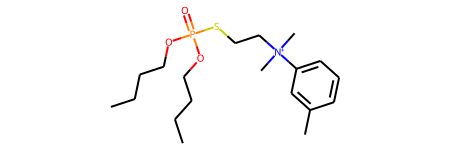

In [272]:
bitID=1819

_m=get_instance_w_bit(bitID, 
                   ms, 
                  )
_m

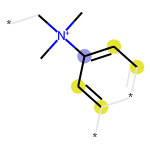

In [273]:
fp,bi=get_fp_bitinfo(_m, )
Draw.DrawMorganBit(_m, bitID, bi, useSVG=True)

Top 5 morgan FP bits are different atoms on the same sub-structure

how is the infogain calculated

Consider finding docking information???

What can we glean from these information???

QSAR model validations??

Are there different classes of binding??

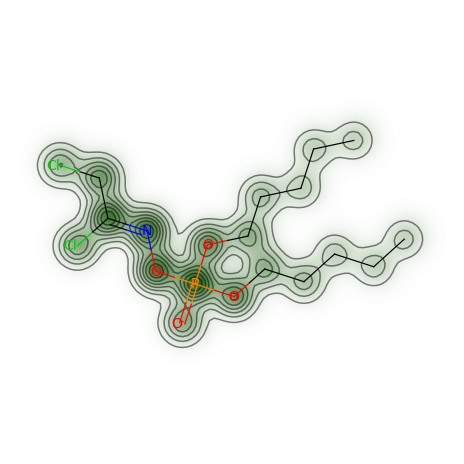

In [266]:
# Similarity Maps Using Fingerprints
bitID = 1848

selected_mols = get_instance_w_bit(bitID,
                                   ms,
                                   return_all=True
                                   )

f, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(
    selected_mols[0],
    selected_mols[1],
    SimilarityMaps.GetMorganFingerprint
)

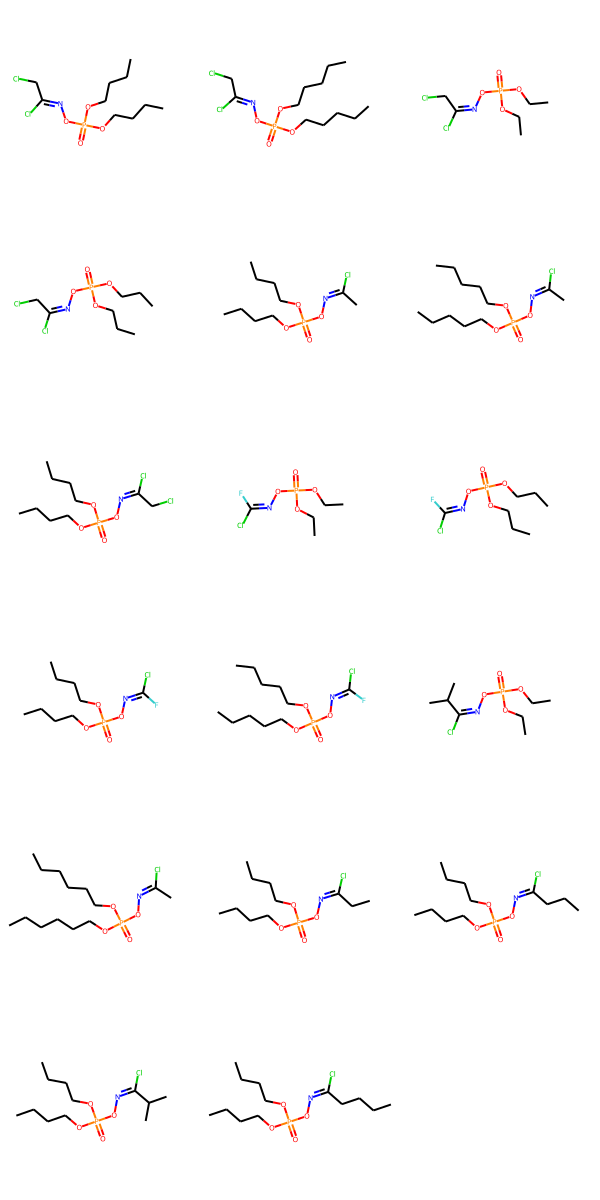

In [267]:
Draw.MolsToGridImage(selected_mols, molsPerRow=3)

Cluster 2 w/ top bitID: phosphosulfate center with cyclo-hexane and 'gamma' sulfur 

C:\Users\cavio\miniconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


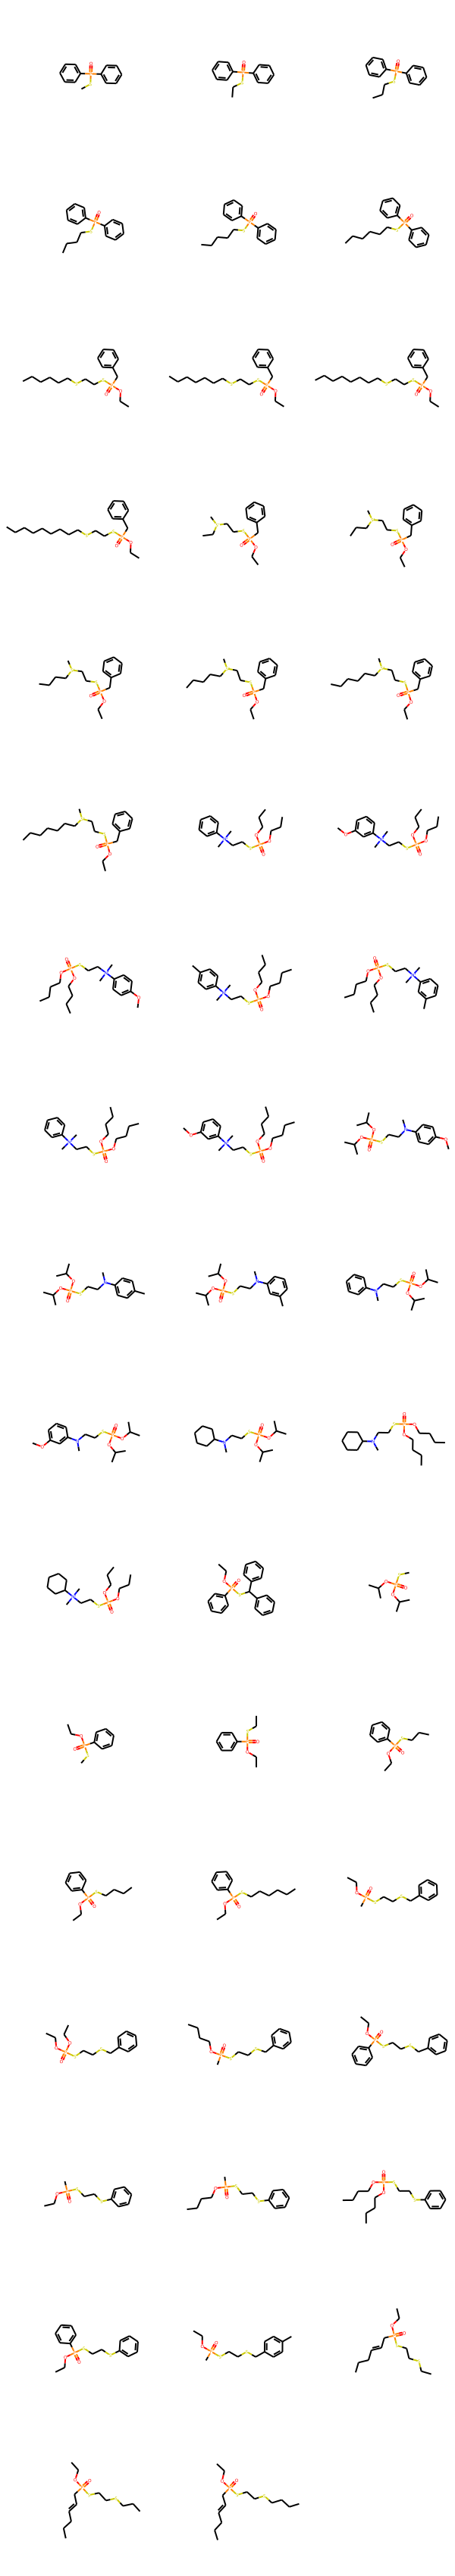

In [239]:
selected_mols=[ms[i] for i in np.where(labels_==cl)[0]]
Draw.MolsToGridImage(selected_mols)

Download more info about these chemicals from CHEMBL and other sources

Consider comparing the clusters between attentions and features, and how some of the chemicals are differentially clustered

### Pick out high Ki compounds

In [244]:
np.argmax(df2['Logki'])

183

In [246]:
df2['Logki'].iloc[183]

8.935

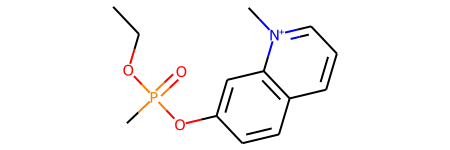

In [247]:
ms[183]

### Maximum common substructure

In [61]:
from rdkit.Chem import rdFMCS
res=rdFMCS.FindMCS([ms[x] for x in clusters[0]])

In [62]:
res.numAtoms

3

In [63]:
res.smartsString

'[#6]-,:[#6]-,:[#6]'